In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ape import accounts, chain, Contract, networks, project

from cauchy_simulations import CauchyLiquidityProfile, ModifiedCauchyLiquidityProfile, from_bps_tick
from cauchy_simulations.profiles.uniswap import UniswapLiquidityProfile

In [26]:
C = 10.0  # total liquidity parameter
GAMMA = 0.1  # scale parameter
MAX_TICK = 887272
TICK_SPACING = 10  # step size between ticks in arrays

In [27]:
clp = CauchyLiquidityProfile(c=C, gamma=GAMMA)

In [28]:
def modified_c(c: int, pm: int) -> float:
    return c / (1 + 1/(1 + pm**2))

In [29]:
# update to use modified cauchy liquidity profile with constant full range liquidity supplement at peg=gamma
PEG = 2 * GAMMA
MC = modified_c(C, 2)
mclp = ModifiedCauchyLiquidityProfile(c=MC, gamma=GAMMA, peg=PEG)

In [30]:
# should be mc / (pi * gamma) * (1 + 1/(1 + (peg/gamma)**2))
np.isclose(mclp.at(0), (MC / (np.pi * GAMMA)) * (1 + 1/(1 + (PEG/GAMMA)**2)))

True

In [31]:
# normalized to prior non-modified liquidity distribution to compare
np.isclose(mclp.at(0), (C / (np.pi * GAMMA)))

True

In [32]:
bps_ticks = np.arange(start=-MAX_TICK, stop=MAX_TICK, step=TICK_SPACING)

In [33]:
df = pd.DataFrame(data={'bps_ticks': bps_ticks, 'log_ticks': from_bps_tick(bps_ticks)})

In [34]:
# plot liquidity profile over ticks
df[f'l(t) [c={C}, g={GAMMA}]'] = clp.at(df['log_ticks'])
df[f'ml(t) [c={MC}, g={GAMMA}, peg={PEG}]'] = mclp.at(df['log_ticks'])

In [35]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","ml(t) [c=8.333333333333334, g=0.1, peg=0.2]"
0,-887272,-88.722764,0.00004,5.305198
1,-887262,-88.721764,0.00004,5.305198
2,-887252,-88.720764,0.00004,5.305198
3,-887242,-88.719764,0.00004,5.305198
4,-887232,-88.718764,0.00004,5.305198
...,...,...,...,...
177450,887228,88.718364,0.00004,5.305198
177451,887238,88.719364,0.00004,5.305198
177452,887248,88.720364,0.00004,5.305198
177453,887258,88.721364,0.00004,5.305198


<Axes: xlabel='bps_ticks'>

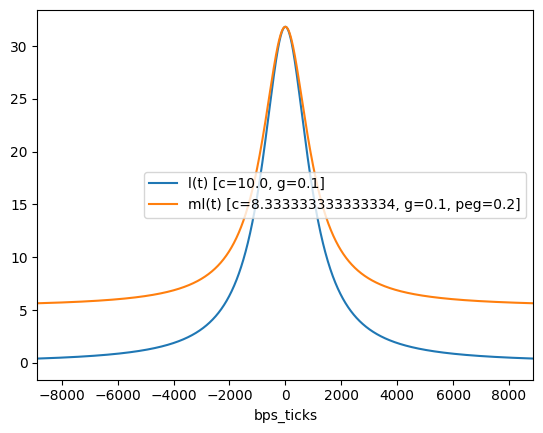

In [36]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={GAMMA}]', f'ml(t) [c={MC}, g={GAMMA}, peg={PEG}]'], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [37]:
# generate for more gammas
gammas = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.5, 1.0])

In [38]:
peg_multiples = [0, 2, 4, 8, 16, 32, 64]

In [39]:
%%capture
# try for various peg multiples of gamma
for g in gammas:
    for pm in peg_multiples:
        peg = pm * g
        mc = modified_c(C, pm)
        df[f'ml(t) [c={mc}, g={g}, peg={peg}]'] = ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).at(df['log_ticks'])

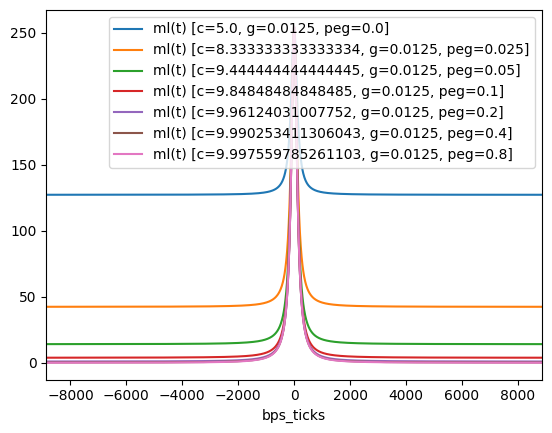

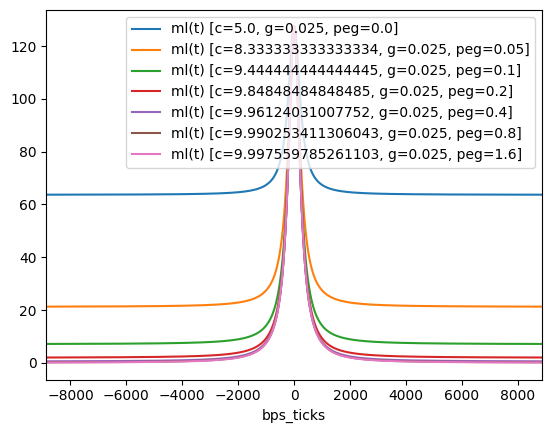

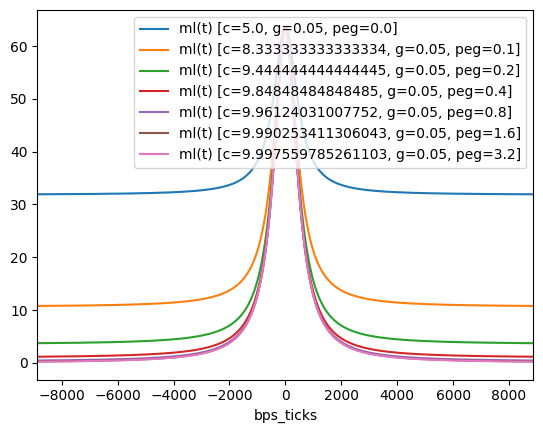

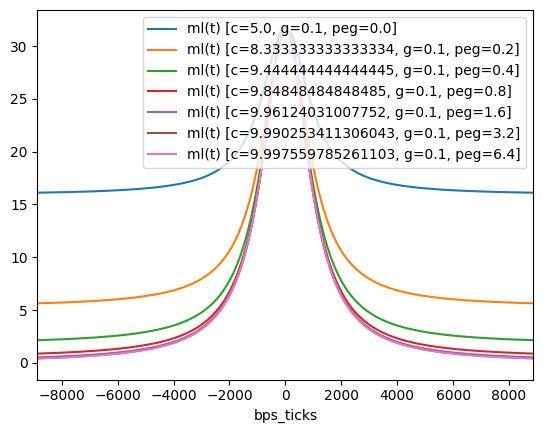

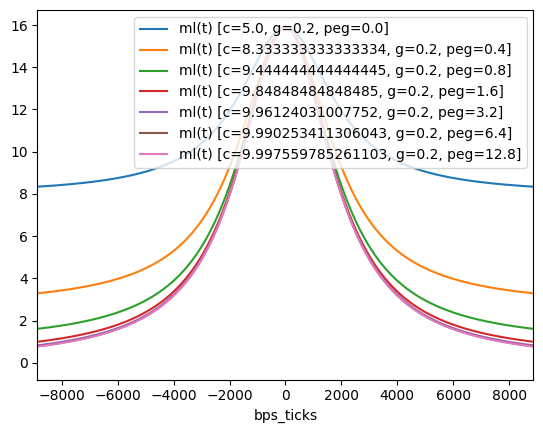

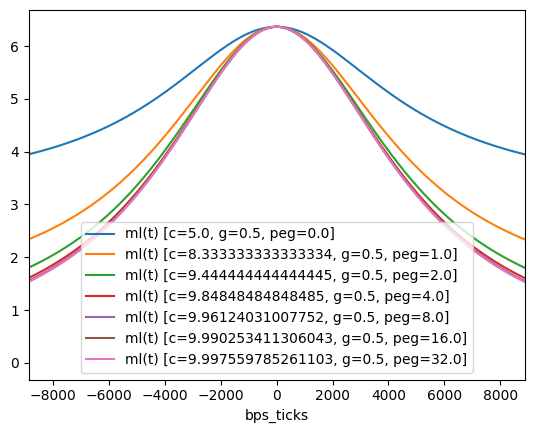

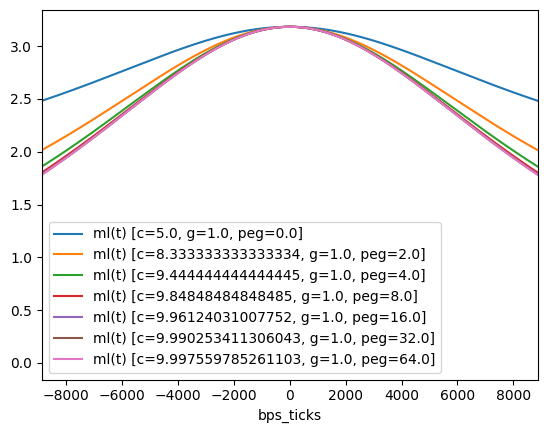

In [40]:
# plot across pegs and gammas
for g in gammas:
    ys = [f'ml(t) [c={modified_c(C, pm)}, g={g}, peg={pm * g}]' for pm in peg_multiples]
    df.plot(x='bps_ticks', y=ys, xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [41]:
# plot slippage curves again, trying for peg. NOTE: cauchy.ppf(0.98) ~ 16 * gamma
PEG_MULTIPLE = 16

In [42]:
# to compare with curve, calculate the amount of x out required to move pool to tick t for various ticks
top = 40000 # bps
width = TICK_SPACING
bps_ticks_in_ranges = np.array([width * i for i in range((top + width) // width)])
df_w_ranges = pd.DataFrame(data={
    'bps_ticks': bps_ticks_in_ranges,
    'log_ticks': from_bps_tick(bps_ticks_in_ranges),
    'price': np.exp(from_bps_tick(bps_ticks_in_ranges)),
    'price^{-1}': np.exp(-from_bps_tick(bps_ticks_in_ranges))
})

In [43]:
%%capture
# calculate relevant curve slippage quantities for different gamma values
for g in gammas:
    peg = PEG_MULTIPLE * g
    mc = modified_c(C, PEG_MULTIPLE)
    print(f"Calculating in/out slippage quantities for gamma: {g}, peg: {peg}, and mc: {mc} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'|xout|/rx0 [c={mc}, g={g}, peg={peg}]'] = np.abs(df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]']) / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'yin/ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]']

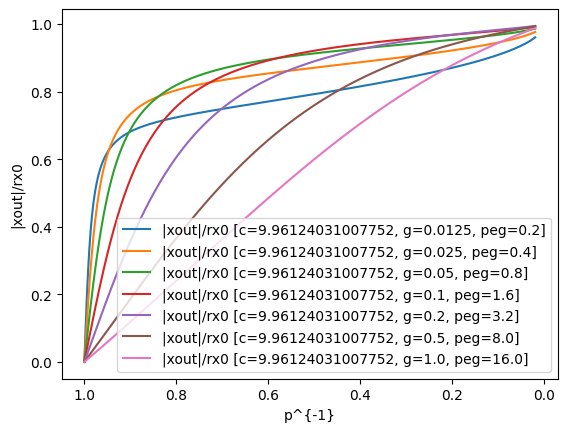

In [44]:
# for modified, plot inverse price vs x out as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas])
ax.invert_xaxis()

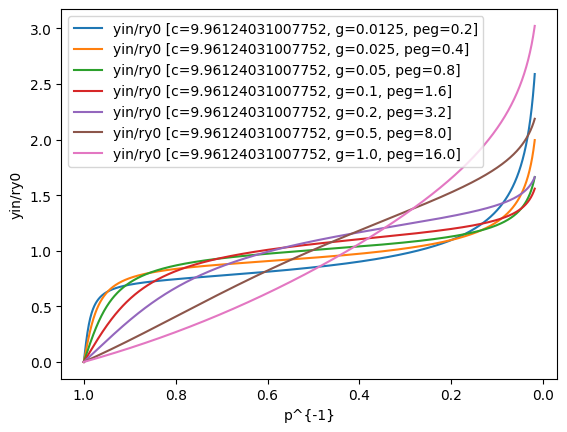

In [45]:
# for modified, plot inverse price vs y in as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas])
ax.invert_xaxis()

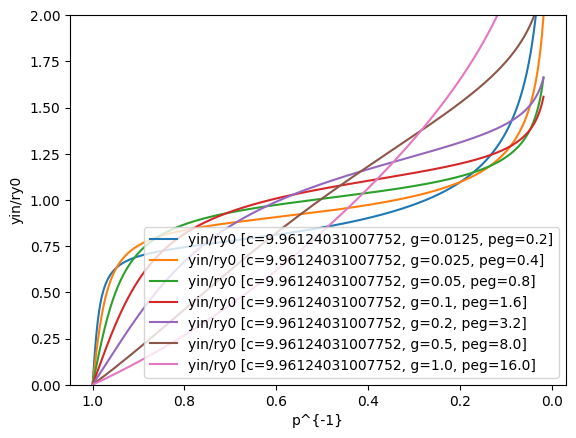

In [48]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, PEG_MULTIPLE)}, g={g}, peg={PEG_MULTIPLE * g}]' for g in gammas], ylim=(0.0, 2.0))
ax.invert_xaxis()

In [49]:
# instead plot across pegs for fixed gamma = 0.0125
for pm in peg_multiples:
    g = gammas[0]
    peg = pm * g
    mc = modified_c(C, pm)
    print(f"Calculating in/out slippage quantities for gamma: {g}, peg: {peg}, and mc: {mc} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'|xout|/rx0 [c={mc}, g={g}, peg={peg}]'] = np.abs(df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]']) / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'yin/ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]']

Calculating in/out slippage quantities for gamma: 0.0125, peg: 0.8, and mc: 9.997559785261103 .....

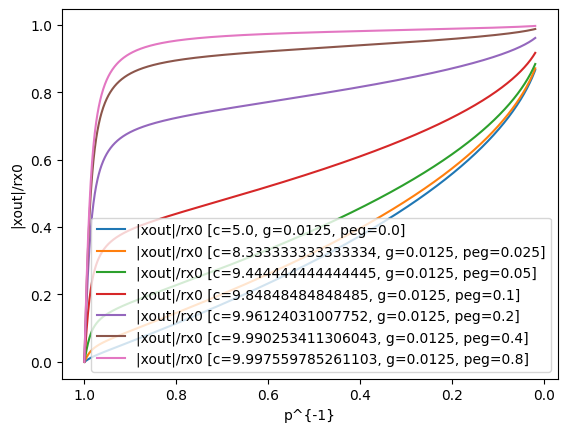

In [50]:
# for modified, plot inverse price vs x out as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples])
ax.invert_xaxis()

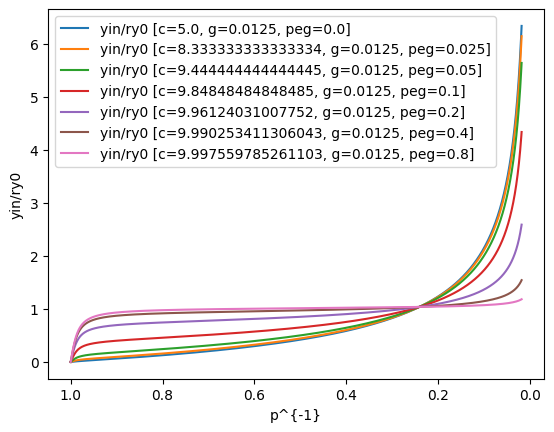

In [51]:
# for modified, plot inverse price vs y in as fraction of initial reserves for different gammas
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples])
ax.invert_xaxis()

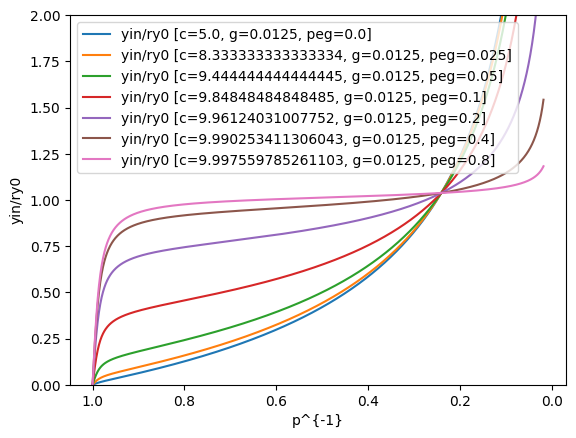

In [52]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples], ylim=(0.0, 2.0))
ax.invert_xaxis()

In [54]:
# plot vs uniswap and curve for comparison

In [57]:
unilp = UniswapLiquidityProfile(c=C)

In [69]:
# plot liquidity profile over ticks
df[f'l(t) [uni c={C}]'] = unilp.at(df['log_ticks'])

In [60]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","ml(t) [c=8.333333333333334, g=0.1, peg=0.2]","ml(t) [c=5.0, g=0.0125, peg=0.0]","ml(t) [c=8.333333333333334, g=0.0125, peg=0.025]","ml(t) [c=9.444444444444445, g=0.0125, peg=0.05]","ml(t) [c=9.84848484848485, g=0.0125, peg=0.1]","ml(t) [c=9.96124031007752, g=0.0125, peg=0.2]","ml(t) [c=9.990253411306043, g=0.0125, peg=0.4]",...,"ml(t) [c=9.990253411306043, g=0.5, peg=16.0]","ml(t) [c=9.997559785261103, g=0.5, peg=32.0]","ml(t) [c=5.0, g=1.0, peg=0.0]","ml(t) [c=8.333333333333334, g=1.0, peg=2.0]","ml(t) [c=9.444444444444445, g=1.0, peg=4.0]","ml(t) [c=9.84848484848485, g=1.0, peg=8.0]","ml(t) [c=9.96124031007752, g=1.0, peg=16.0]","ml(t) [c=9.990253411306043, g=1.0, peg=32.0]","ml(t) [c=9.997559785261103, g=1.0, peg=64.0]",unil(t) [c=10.0]
0,-887272,-88.722764,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
1,-887262,-88.721764,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
2,-887252,-88.720764,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
3,-887242,-88.719764,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
4,-887232,-88.718764,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
177451,887238,88.719364,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
177452,887248,88.720364,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0
177453,887258,88.721364,0.00004,5.305198,127.323957,42.441322,14.147111,3.858307,0.987012,0.2482,...,0.006407,0.001756,1.591752,0.530853,0.177221,0.048627,0.01274,0.003506,0.001181,10.0


<Axes: xlabel='bps_ticks'>

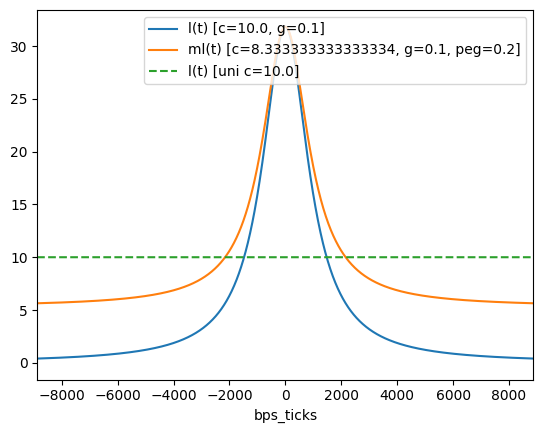

In [95]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={GAMMA}]', f'ml(t) [c={MC}, g={GAMMA}, peg={PEG}]', f'l(t) [uni c={C}]'], xlim=(-MAX_TICK // 100, MAX_TICK // 100), style=['-', '-', '--'])

In [73]:
# xout, yin and initial reserves
df_w_ranges[f'xout [uni c={C}]'] = df_w_ranges['bps_ticks'].apply(lambda t: unilp.cost_x(from_bps_tick(0), from_bps_tick(t)))
df_w_ranges[f'yin [uni c={C}]'] = df_w_ranges['bps_ticks'].apply(lambda t: unilp.cost_y(from_bps_tick(0), from_bps_tick(t)))
df_w_ranges[f'rx0 [uni c={C}]'] = df_w_ranges['bps_ticks'].apply(lambda t: unilp.reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
df_w_ranges[f'ry0 [uni c={C}]'] = df_w_ranges['bps_ticks'].apply(lambda t: unilp.reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

# ratios for plotting
df_w_ranges[f'xout/rx0 [uni c={C}]'] = df_w_ranges[f'xout [uni c={C}]'] / df_w_ranges[f'rx0 [uni c={C}]']
df_w_ranges[f'|xout|/rx0 [uni c={C}]'] = np.abs(df_w_ranges[f'xout [uni c={C}]']) / df_w_ranges[f'rx0 [uni c={C}]']
df_w_ranges[f'yin/ry0 [uni c={C}]'] = df_w_ranges[f'yin [uni c={C}]'] / df_w_ranges[f'ry0 [uni c={C}]']

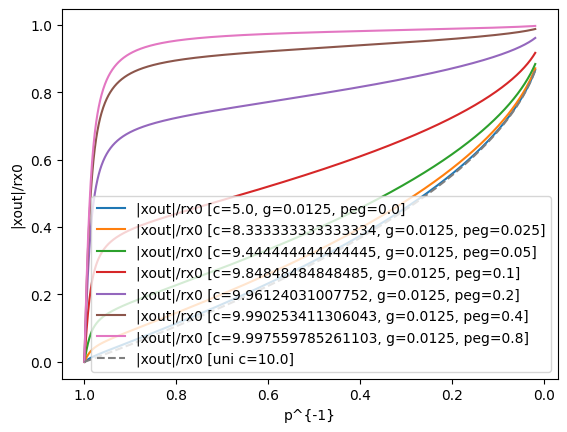

In [80]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples] + [f'|xout|/rx0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples] + [f'|xout|/rx0 [uni c={C}]'], style=['-' for _ in range(len(peg_multiples))] + ['--'])
ax.invert_xaxis()

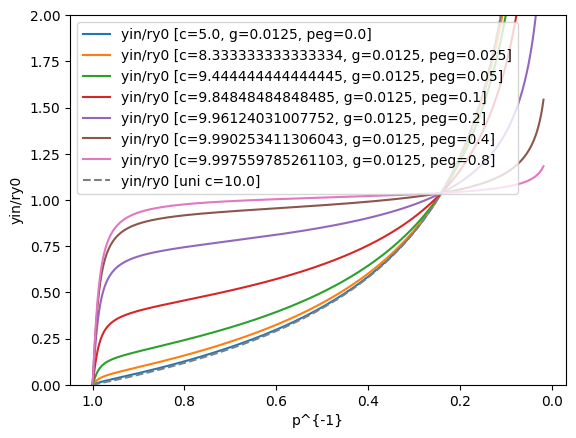

In [100]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples] + [f'yin/ry0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[0]}, peg={pm * gammas[0]}]' for pm in peg_multiples] + [f'yin/ry0 [uni c={C}]'], ylim=(0.0, 2.0), style=['-' for _ in range(len(peg_multiples))] + ['--'])
ax.invert_xaxis()

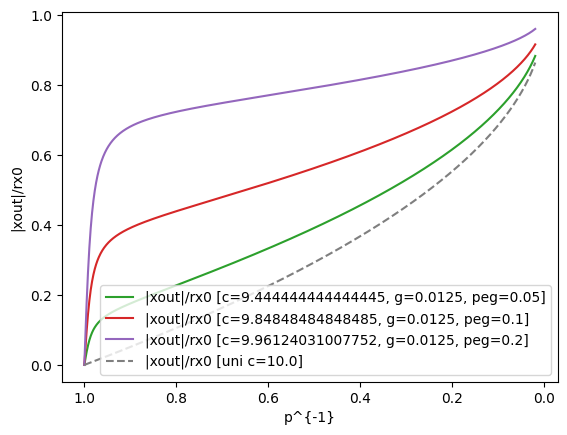

In [115]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, peg_multiples[2])}, g={gammas[0]}, peg={peg_multiples[2] * gammas[0]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[3])}, g={gammas[0]}, peg={peg_multiples[3] * gammas[0]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[4])}, g={gammas[0]}, peg={peg_multiples[4] * gammas[0]}]'] + [f'|xout|/rx0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, peg_multiples[2])}, g={gammas[0]}, peg={peg_multiples[2] * gammas[0]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[3])}, g={gammas[0]}, peg={peg_multiples[3] * gammas[0]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[4])}, g={gammas[0]}, peg={peg_multiples[4] * gammas[0]}]'] + [f'|xout|/rx0 [uni c={C}]'], style=['-', '-', '-'] + ['--'], color=['C2', 'C3', 'C4', 'C7'])
ax.invert_xaxis()

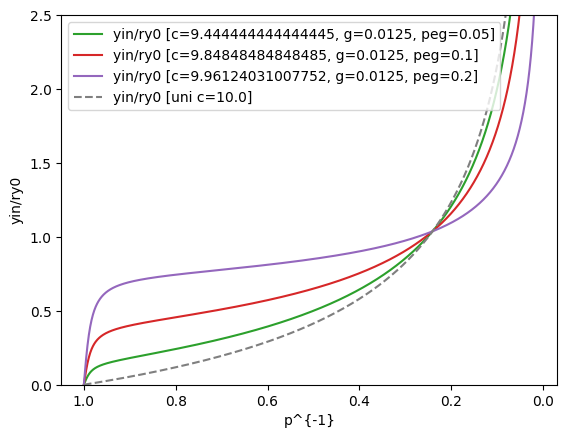

In [116]:
# far steeper drop off than uniswap in transition from constant sum to constant product
# but eventually slopes toward uniswap behavior
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, peg_multiples[2])}, g={gammas[0]}, peg={peg_multiples[2] * gammas[0]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[3])}, g={gammas[0]}, peg={peg_multiples[3] * gammas[0]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[4])}, g={gammas[0]}, peg={peg_multiples[4] * gammas[0]}]'] + [f'yin/ry0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, peg_multiples[2])}, g={gammas[0]}, peg={peg_multiples[2] * gammas[0]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[3])}, g={gammas[0]}, peg={peg_multiples[3] * gammas[0]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[4])}, g={gammas[0]}, peg={peg_multiples[4] * gammas[0]}]'] + [f'yin/ry0 [uni c={C}]'], style=['-', '-', '-'] + ['--'], color=['C2', 'C3', 'C4', 'C7'], ylim=(0, 2.5))
ax.invert_xaxis()

In [109]:
# look at less levered gamma
# instead plot across pegs for fixed gamma = 0.05
for pm in peg_multiples:
    g = gammas[2]
    peg = pm * g
    mc = modified_c(C, pm)
    print(f"Calculating in/out slippage quantities for gamma: {g}, peg: {peg}, and mc: {mc} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'|xout|/rx0 [c={mc}, g={g}, peg={peg}]'] = np.abs(df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]']) / df_w_ranges[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df_w_ranges[f'yin/ry0 [c={mc}, g={g}, peg={peg}]'] = df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] / df_w_ranges[f'ry0 [c={mc}, g={g}, peg={peg}]']

Calculating in/out slippage quantities for gamma: 0.05, peg: 0.0, and mc: 5.0 ...

/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda

Calculating in/out slippage quantities for gamma: 0.05, peg: 0.1, and mc: 8.333333333333334 ...

/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda

Calculating in/out slippage quantities for gamma: 0.05, peg: 0.2, and mc: 9.444444444444445 ...

/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda

Calculating in/out slippage quantities for gamma: 0.05, peg: 0.4, and mc: 9.84848484848485 ...

/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda

Calculating in/out slippage quantities for gamma: 0.05, peg: 1.6, and mc: 9.990253411306043 ...

/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda

Calculating in/out slippage quantities for gamma: 0.05, peg: 3.2, and mc: 9.997559785261103 ...

/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'xout [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
/var/folders/sh/82_2395n0wjdnk572g0xzt9c0000gp/T/ipykernel_54325/2276545977.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_w_ranges[f'yin [c={mc}, g={g}, peg={peg}]'] = df_w_ranges['bps_ticks'].apply(lambda

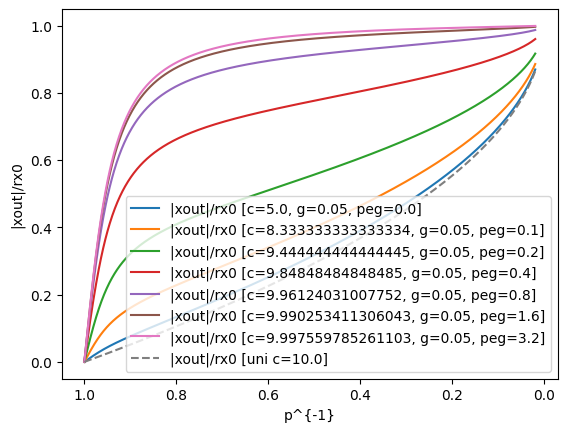

In [110]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples] + [f'|xout|/rx0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples] + [f'|xout|/rx0 [uni c={C}]'], style=['-' for _ in range(len(peg_multiples))] + ['--'])
ax.invert_xaxis()

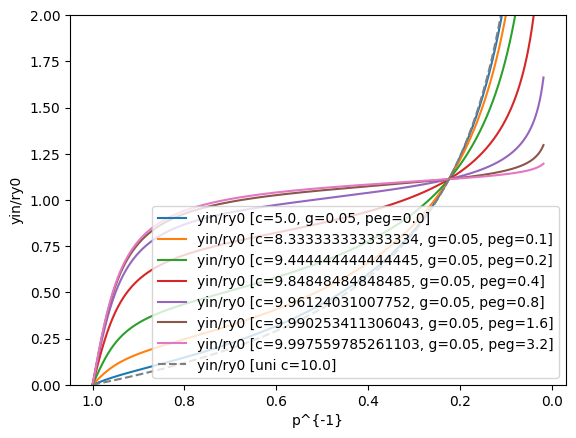

In [111]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples] + [f'yin/ry0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, pm)}, g={gammas[2]}, peg={pm * gammas[2]}]' for pm in peg_multiples] + [f'yin/ry0 [uni c={C}]'], ylim=(0.0, 2.0), style=['-' for _ in range(len(peg_multiples))] + ['--'])
ax.invert_xaxis()

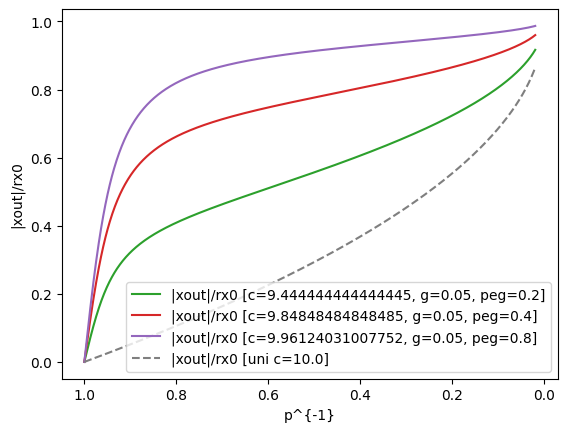

In [118]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={modified_c(C, peg_multiples[2])}, g={gammas[2]}, peg={peg_multiples[2] * gammas[2]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[3])}, g={gammas[2]}, peg={peg_multiples[3] * gammas[2]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[4])}, g={gammas[2]}, peg={peg_multiples[4] * gammas[2]}]'] + [f'|xout|/rx0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={modified_c(C, peg_multiples[2])}, g={gammas[2]}, peg={peg_multiples[2] * gammas[2]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[3])}, g={gammas[2]}, peg={peg_multiples[3] * gammas[2]}]', f'|xout|/rx0 [c={modified_c(C, peg_multiples[4])}, g={gammas[2]}, peg={peg_multiples[4] * gammas[2]}]'] + [f'|xout|/rx0 [uni c={C}]'], style=['-', '-', '-'] + ['--'], color=['C2', 'C3', 'C4', 'C7'])
ax.invert_xaxis()

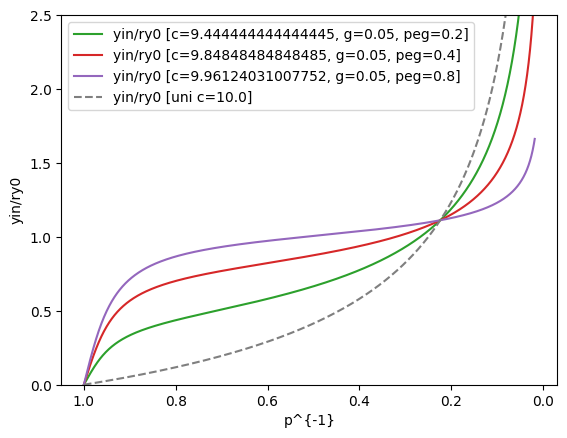

In [123]:
# peg multiple probably should decrease a bit as gamma increases,
# to potentially calibrate based on yin/ry0 point at which constant sum curve breaks and slippage drastically increases
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={modified_c(C, peg_multiples[2])}, g={gammas[2]}, peg={peg_multiples[2] * gammas[2]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[3])}, g={gammas[2]}, peg={peg_multiples[3] * gammas[2]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[4])}, g={gammas[2]}, peg={peg_multiples[4] * gammas[2]}]'] + [f'yin/ry0 [uni c={C}]'], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={modified_c(C, peg_multiples[2])}, g={gammas[2]}, peg={peg_multiples[2] * gammas[2]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[3])}, g={gammas[2]}, peg={peg_multiples[3] * gammas[2]}]', f'yin/ry0 [c={modified_c(C, peg_multiples[4])}, g={gammas[2]}, peg={peg_multiples[4] * gammas[2]}]'] + [f'yin/ry0 [uni c={C}]'], style=['-', '-', '-'] + ['--'], color=['C2', 'C3', 'C4', 'C7'], ylim=(0, 2.5))
ax.invert_xaxis()